#   Bibliotecas

- Versões das bibliotecas no README

In [1]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack #utilizada para a junção de matrizes


In [2]:
#Pré processamento de colunas

from sklearn.model_selection import train_test_split #Divisão do dataset entre treino e teste
from sklearn.feature_extraction.text import TfidfVectorizer #vetorização do dataset
from sklearn.preprocessing import OneHotEncoder #aplicação de dummy

In [3]:
#Pré processamento de texto


import nltk
from nltk import word_tokenize #tokenizador
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords   #stopword

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
#import de funções do script de pre_processamento

from pre_processamento import pre_processamento, text_preprocess, textcolumns_junct,stemming

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
import tensorflow as tf

In [8]:
# Modelo a ser testado
import tensorflow as tf
from keras import layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 811995725537835362
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9003764608995599941
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [10]:
#metricas

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [ ]:
train = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\train.tsv", sep='\t')
test = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\test.tsv", sep='\t')

In [ ]:
train,test = pre_processamento(train,test)

#   Pré-processamento 

In [ ]:
train = textcolumns_junct(train) #Função pra juntar as colunas de texto em uma só coluna

In [ ]:
#Convertendo tudo para string

train["item_description"] = train["item_description"].astype(str)

In [ ]:
train["item_description"] = train["item_description"].apply(lambda x: text_preprocess(x)) #Limpando texto com regex.

In [ ]:
train["item_description"] = train["item_description"].apply(lambda x: word_tokenize(x)) #tokenizando

In [ ]:
train["item_description"] = train["item_description"].apply(lambda x: stemming(x))

In [ ]:
train["item_description"]=[" ".join(review) for review in train["item_description"].values]

In [ ]:
train["item_description"]

In [ ]:
train.shape

In [11]:
train = pd.read_pickle("/content/drive/MyDrive/Datasets/train.pkl") 

#   Split

In [12]:
#treinando o modelo com valores até $50, que representam 89% do dataset
train1 = train.drop(train[~((train['price'] > 0) & (train['price'] <= 250))].index)

In [13]:
train.shape

(1481661, 11)

In [14]:
X = train1.drop("price", axis = 1)
y = train1["price"]

In [15]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de teste de possíveis vazamentos e das mudanças de hyperparametros. 

X1, Xtest, y1, ytest = train_test_split(X, y, test_size=0.1, random_state=10) #Divisão em 90/10

In [16]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 

Xtrain, Xval, ytrain, yval = train_test_split(X1, y1, test_size=0.2, random_state=10) #Divisão em 80/20

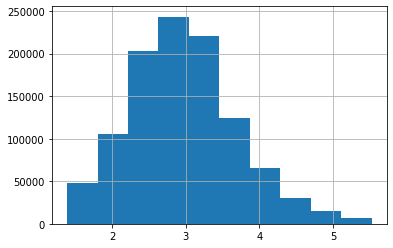

In [17]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

ytrain =  np.log1p(ytrain)
ytrain.hist()

In [18]:
print(Xtrain.shape,ytrain.shape) 
print(Xval.shape,yval.shape)
print(Xtest.shape,ytest.shape)

(1062384, 10) (1062384,)
(265596, 10) (265596,)
(147554, 10) (147554,)


# Transformadores

In [19]:
vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_features=25000) #vetorização, com stop word. 

In [20]:
vec_train = vec.fit_transform(Xtrain["item_description"])

vec_train

<1062384x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 26265778 stored elements in Compressed Sparse Row format>

In [21]:
vec_val = vec.transform(Xval["item_description"])

vec_val

<265596x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 6566046 stored elements in Compressed Sparse Row format>

In [22]:
ohe = OneHotEncoder(handle_unknown="ignore")

#aplicação dummy nas colunas categóricas.

ohe_train = ohe.fit_transform(Xtrain[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])
                            
ohe_train

<1062384x985 sparse matrix of type '<class 'numpy.float64'>'
	with 5311920 stored elements in Compressed Sparse Row format>

In [23]:
ohe_val = ohe.transform(Xval[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])

ohe_val

<265596x985 sparse matrix of type '<class 'numpy.float64'>'
	with 1327960 stored elements in Compressed Sparse Row format>

In [24]:
#juntando cada matrix gerada por cada pré-processamento

x_train = hstack([
                 (vec_train),
                 (ohe_train)
                            ], format='csr') 
x_train

<1062384x25985 sparse matrix of type '<class 'numpy.float64'>'
	with 31577698 stored elements in Compressed Sparse Row format>

In [25]:
x_val = hstack([
                 (vec_val),
                 (ohe_val)
                             ], format='csr') 
x_val

<265596x25985 sparse matrix of type '<class 'numpy.float64'>'
	with 7894006 stored elements in Compressed Sparse Row format>

# Modelo

In [26]:
#del model  # for avoid any trace on aigen
tf.keras.backend.clear_session()  # removing session, it will instance another

In [27]:
input = Input(shape=(x_train.shape[-1]), sparse=True, name='sparse')
dense3 = Dense(1024, activation="relu") (input)
dense4 = Dense(1024, activation="relu") (dense3)
dense5 = Dense(1024, activation="relu") (dense4)
out = Dense(1) (dense5)

model = Model(inputs = input, outputs = out)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sparse (InputLayer)         [(None, 25985)]           0         
                                                                 
 dense (Dense)               (None, 1024)              26609664  
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 28,709,889
Trainable params: 28,709,889
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss="mean_squared_error", 
              metrics=['mean_squared_error', RootMeanSquaredError()], 
              optimizer = 'Adam')



In [29]:
x_train.sort_indices()

In [30]:

history =  model.fit(x_train,
                     ytrain.values, 
                     batch_size=2048,
                     epochs=25, 
                     verbose=True)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


519/519 [==============================] - 28s 45ms/step - loss: 0.2944 - mean_squared_error: 0.2944 - root_mean_squared_error: 0.5426
Epoch 2/25
519/519 [==============================] - 26s 46ms/step - loss: 0.1775 - mean_squared_error: 0.1775 - root_mean_squared_error: 0.4213
Epoch 3/25
519/519 [==============================] - 26s 45ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - root_mean_squared_error: 0.3655
Epoch 4/25
519/519 [==============================] - 26s 45ms/step - loss: 0.0923 - mean_squared_error: 0.0923 - root_mean_squared_error: 0.3038
Epoch 5/25
519/519 [==============================] - 26s 45ms/step - loss: 0.0646 - mean_squared_error: 0.0646 - root_mean_squared_error: 0.2541
Epoch 6/25
519/519 [==============================] - 26s 45ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - root_mean_squared_error: 0.2191
Epoch 7/25
519/519 [==============================] - 26s 46ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - root_mean_squared_err

In [31]:
x_val.sort_indices()

In [32]:
ypredict = model.predict(x_val)

8300/8300 [==============================] - 21s 2ms/step


In [33]:
ypredict = np.expm1(ypredict)


#   Resultado

- predict validação

In [34]:
print('MAE: $ %.2f' %  mean_absolute_error(yval,ypredict))
print('RMSE:  $ %.2f' %  (mean_squared_error(yval,ypredict)**0.5))
print('RMSLE: %2f' % mean_squared_log_error(yval,ypredict))


MAE: $ 9.34
RMSE:  $ 17.99
RMSLE: 0.212418


#   Predição no teste

In [35]:
vec_test = vec.transform(Xtest["item_description"])

In [36]:
ohe_test = ohe.transform(Xtest[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])
                            
ohe_test

<147554x985 sparse matrix of type '<class 'numpy.float64'>'
	with 737763 stored elements in Compressed Sparse Row format>

In [37]:
xtest = hstack([
                 (vec_test),
                 (ohe_test)
                             ], format='csr') 
xtest

<147554x25985 sparse matrix of type '<class 'numpy.float64'>'
	with 4396900 stored elements in Compressed Sparse Row format>

In [38]:
xtest.sort_indices()

In [58]:
ypredict_test = model.predict(xtest)
ypredict_test = np.expm1(ypredict_test)

4612/4612 [==============================] - 12s 3ms/step


In [59]:
print('MAE: $ %.2f' %  mean_absolute_error(ytest,ypredict_test))
print('RMSE:  $ %.2f' %  (mean_squared_error(ytest,ypredict_test)**0.5))
print('RMSLE: %2f' % mean_squared_log_error(ytest,ypredict_test))

MAE: $ 9.36
RMSE:  $ 18.14
RMSLE: 0.211265


# Teste para produtos até $50

In [60]:
teste50 = pd.concat([Xtest,ytest], axis=1)
teste50 = teste50.loc[teste50["price"]<=50]

In [61]:
X50 = teste50.drop("price", axis = 1)
y50 = teste50 ["price"]

In [62]:
vec50 = vec.transform(X50["item_description"])

In [63]:
ohe50 = ohe.transform(X50[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])
                            
ohe50

<133179x985 sparse matrix of type '<class 'numpy.float64'>'
	with 665890 stored elements in Compressed Sparse Row format>

In [64]:
x50 = hstack([
                 (vec50),
                 (ohe50)
                             ], format='csr') 
x50

<133179x25985 sparse matrix of type '<class 'numpy.float64'>'
	with 3938402 stored elements in Compressed Sparse Row format>

In [65]:
x50.sort_indices()

In [66]:
ypredict50 = model.predict(x50)
ypredict50 = np.expm1(ypredict50)

4162/4162 [==============================] - 10s 3ms/step


In [67]:
print('MAE: $ %.2f' %  mean_absolute_error(y50,ypredict50))
print('RMSE:  $ %.2f' %  (mean_squared_error(y50,ypredict50)**0.5))
print('RMSLE: %2f' % mean_squared_log_error(y50,ypredict50))

MAE: $ 6.39
RMSE:  $ 9.78
RMSLE: 0.177031


# Teste para produtos entre 50 e 250

In [68]:
teste250 = pd.concat([Xtest,ytest], axis=1)
teste250 = teste250.loc[(teste250["price"]>50) & (teste250["price"]<=250)]

In [69]:
X250 = teste250.drop("price", axis = 1)
y250 = teste250 ["price"]

In [70]:
X250.shape

(14375, 10)

In [71]:
vec250 = vec.transform(X250["item_description"])

In [72]:
ohe250 = ohe.transform(X250[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])
                            
ohe250

<14375x985 sparse matrix of type '<class 'numpy.float64'>'
	with 71873 stored elements in Compressed Sparse Row format>

In [73]:
x250 = hstack([
                 (vec250),
                 (ohe250)
                             ], format='csr') 
x250

<14375x25985 sparse matrix of type '<class 'numpy.float64'>'
	with 458498 stored elements in Compressed Sparse Row format>

In [74]:
x250.sort_indices()

In [75]:
ypredict250 = model.predict(x250)
ypredict250 = np.expm1(ypredict250)

450/450 [==============================] - 1s 3ms/step


In [76]:
print('MAE: $ %.2f' %  mean_absolute_error(y250,ypredict250))
print('RMSE:  $ %.2f' %  (mean_squared_error(y250,ypredict250)**0.5))
print('RMSLE: %2f' % mean_squared_log_error(y250,ypredict250))

MAE: $ 36.83
RMSE:  $ 49.91
RMSLE: 0.528429


Aparente sinal de overfitting